In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

In [2]:
df = pd.read_csv('fraud_oracle.csv')

In [3]:
df.head()
print(df["FraudFound_P"].value_counts())

FraudFound_P
0    14497
1      923
Name: count, dtype: int64


In [4]:
#Dimension du dataset
print(f"Dimensions du dataset : {df.shape[0]} lignes et {df.shape[1]} colonnes\n")

Dimensions du dataset : 15420 lignes et 33 colonnes



Si FraudFound_P = 1 alors il y a fraude, Sinon si FraudFound_P = 0, non fraude.

Il s'agit donc d'un problème de classification binaire.

In [5]:
print("Distribution de la fraude :")
print(df['FraudFound_P'].value_counts(normalize=False))

Distribution de la fraude :
FraudFound_P
0    14497
1      923
Name: count, dtype: int64


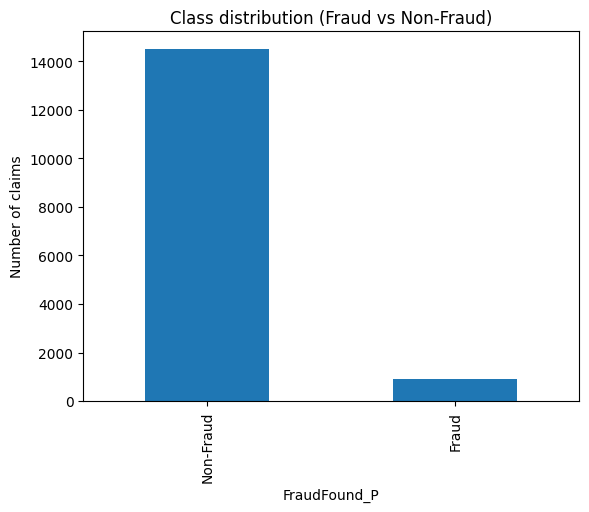

In [6]:
#Histogramme pour représenter la proportion de fraude et de non fraude
class_counts = df['FraudFound_P'].value_counts()

# Histogramme
plt.figure()
class_counts.plot(kind='bar')

plt.xlabel("FraudFound_P")
plt.ylabel("Number of claims")
plt.title("Class distribution (Fraud vs Non-Fraud)")

plt.xticks([0,1], ['Non-Fraud', 'Fraud'])

plt.show()

In [7]:
df['RepNumber'] = df['RepNumber'].astype('object')

In [8]:
detail_nas = pd.concat([df.dtypes,df.isnull().sum()],axis=1)
detail_nas.columns=['FORMAT','NB_NA']
detail_nas


,FORMAT,NB_NA
Month,object,0
WeekOfMonth,int64,0
DayOfWeek,object,0
Make,object,0
AccidentArea,object,0
DayOfWeekClaimed,object,0
MonthClaimed,object,0
WeekOfMonthClaimed,int64,0
Sex,object,0
MaritalStatus,object,0


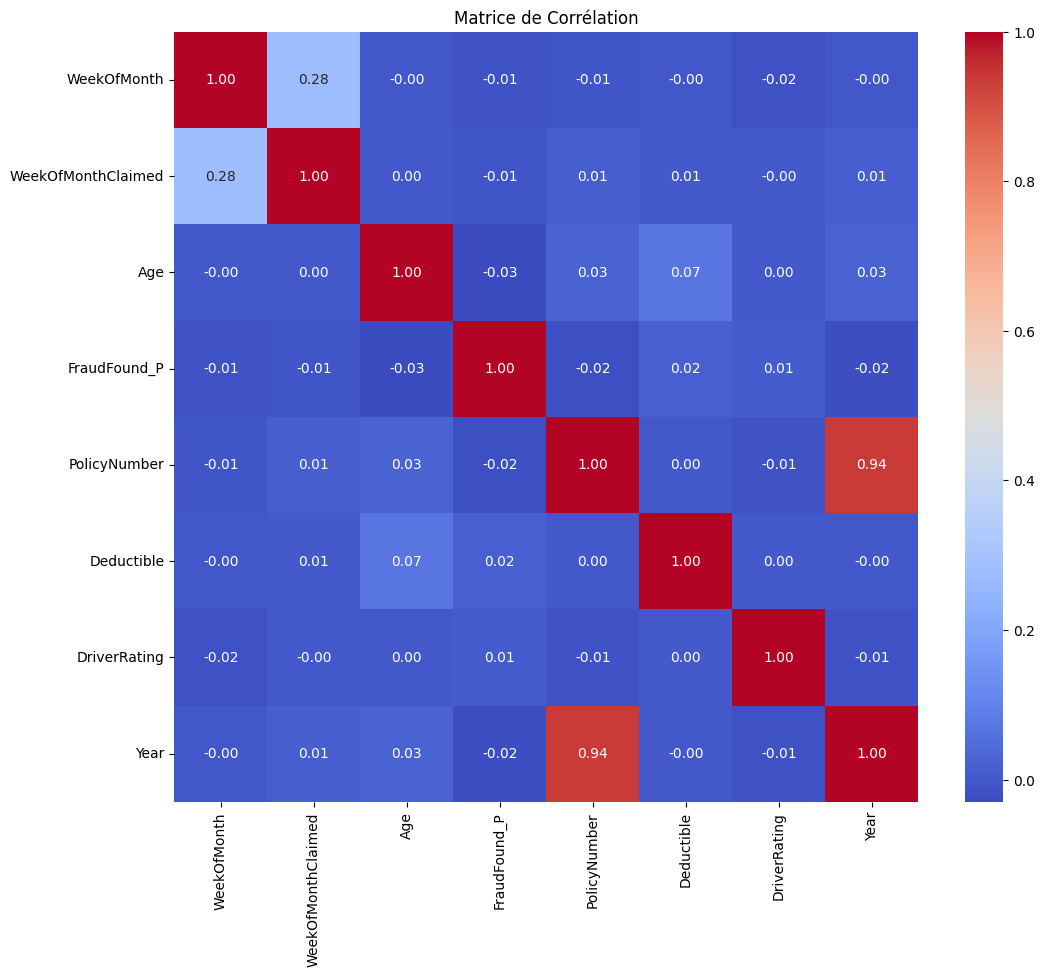

In [9]:
plt.figure(figsize=(12,10))
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(), annot=True,fmt=".2f", cmap='coolwarm')
plt.title('Matrice de Corrélation')
plt.show()

In [10]:
from scipy.stats.contingency import association

#Sélection des variables qualitatives (type 'object')

# On exclut la cible elle-même et les colonnes de type ID ou dates trop complexes
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cols_to_exclude = ['FraudFound_P']
variables_qualitatives = [col for col in cat_cols if col not in cols_to_exclude]

# Calcul du V de Cramer par rapport à 'fraud_reported'
resultats = []
for col in variables_qualitatives:
    # Création du tableau de contingence (croisement des fréquences)
    table = pd.crosstab(df[col], df['FraudFound_P'])

    # Utilisation de la fonction Scipy (Scipy version 1.7.0+)
    v_cramer = association(table, method="cramer")

    resultats.append({
        'Variable': col,
        'V de Cramer': round(v_cramer, 4)
    })

# 5. Création du tableau synthétique trié
tableau_v_cramer = pd.DataFrame(resultats).sort_values(by='V de Cramer', ascending=False)

# Affichage du tableau
print("Association des variables qualitatives avec la fraude (V de Cramer) :")
print(tableau_v_cramer.to_string(index=False))


Association des variables qualitatives avec la fraude (V de Cramer) :
            Variable  V de Cramer
          PolicyType       0.1684
          BasePolicy       0.1616
     VehicleCategory       0.1374
               Fault       0.1314
 AddressChange_Claim       0.0824
        VehiclePrice       0.0663
                Make       0.0623
  PastNumberOfClaims       0.0589
        MonthClaimed       0.0524
   AgeOfPolicyHolder       0.0463
               Month       0.0440
        AgeOfVehicle       0.0377
 NumberOfSuppliments       0.0343
        AccidentArea       0.0335
                 Sex       0.0300
           RepNumber       0.0277
Days_Policy_Accident       0.0274
           DayOfWeek       0.0257
           AgentType       0.0230
    DayOfWeekClaimed       0.0183
   Days_Policy_Claim       0.0178
   PoliceReportFiled       0.0160
        NumberOfCars       0.0125
       MaritalStatus       0.0081
      WitnessPresent       0.0081


In [11]:
cols_to_drop = [
    'WitnessPresent', 'MaritalStatus', 'PoliceReportFiled', 'NumberOfCars',
    'Days_Policy_Claim', 'Days_Policy_Accident', 'AgentType', 'RepNumber',
    'Month', 'WeekOfMonth', 'DayOfWeek', 'DayOfWeekClaimed', 'MonthClaimed',
    'WeekOfMonthClaimed', 'PolicyNumber', 'Age'
]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

print("Shape après nettoyage :", df.shape)

#Encodage sur les variables
df_encoded = pd.get_dummies(df, drop_first=True)   # one-hot sur les object

X = df_encoded.drop(columns=['FraudFound_P']).values.astype(np.float32)
y = df_encoded['FraudFound_P'].values.astype(np.float32)


Shape après nettoyage : (15420, 17)


In [12]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)
for name, arr in [("Train", X_train), ("Validation", X_valid), ("Test", X_test)]:
    print(f"{name:12} : {arr.shape}")

Train        : (9252, 66)
Validation   : (3084, 66)
Test         : (3084, 66)


In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [14]:
#Gestion du déséquilibre des classes
classes      = np.unique(y_train)
weights      = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight = dict(zip(classes.astype(int), weights))
print("\nClass weights :", class_weight)


Class weights : {np.int64(0): np.float64(0.5318464014716027), np.int64(1): np.float64(8.350180505415162)}


In [15]:
n_features = X_train.shape[1]
print("Nombre de features :", n_features)
#modélisation du reseau de neurone
model = keras.models.Sequential([
        keras.layers.Input(shape=[n_features]),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1,   activation="sigmoid")
    ])

#Comme dans le TP de Deep Learning, nous avons
#Pour la première couche : 256 * (66+1) = 17152
#Pour la deuxième couche : 128 * (256+1) = 32896
#Pour la première couche : 1 * (128+1) = 129
#Au total, nous avons : 50177 paramètres, on doit ainsi trouver ce meme
#nombre quand on fait model.summary()

model.summary()


Nombre de features : 66


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,177 (196.00 KB)

 Trainable params: 50,177 (196.00 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(loss="binary_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=1e-3),
        metrics=["accuracy"]
    )

In [17]:
#entrainement du modèle
epochs = 20
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))


Epoch 1/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8000 - loss: 0.5205 - val_accuracy: 0.9403 - val_loss: 0.3314
Epoch 2/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9409 - loss: 0.3208 - val_accuracy: 0.9403 - val_loss: 0.2750
Epoch 3/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9381 - loss: 0.2931 - val_accuracy: 0.9403 - val_loss: 0.2551
Epoch 4/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9394 - loss: 0.2698 - val_accuracy: 0.9403 - val_loss: 0.2463
Epoch 5/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9390 - loss: 0.2696 - val_accuracy: 0.9403 - val_loss: 0.2411
Epoch 6/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9412 - loss: 0.2599 - val_accuracy: 0.9403 - val_loss: 0.2374
Epoch 7/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9395 - loss: 0.2597 - val_accuracy: 0.9403 - val_loss: 0.2345
Epoch 8/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9425 - loss: 0.2452 - val_accuracy: 0

In [18]:
historic = pd.DataFrame(history.history)
historic.head()

,accuracy,loss,val_accuracy,val_loss
0,0.873973,0.448167,0.940337,0.331365
1,0.939364,0.315322,0.940337,0.275037
2,0.939797,0.283467,0.940337,0.255142
3,0.940121,0.270117,0.940337,0.246318
4,0.940121,0.265751,0.940337,0.241111


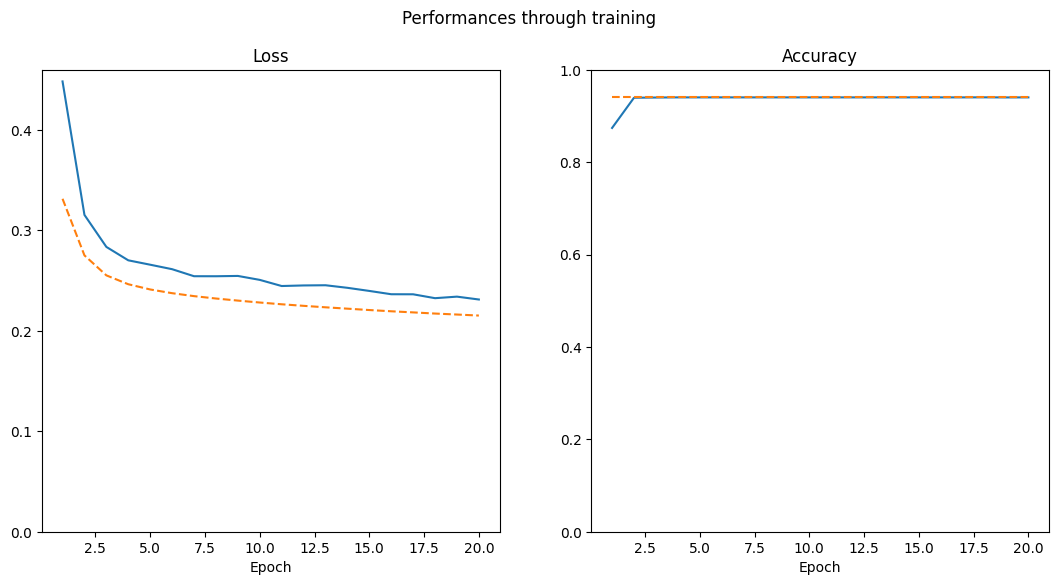

In [19]:
def plot_learning_curves(history, figsize=(13, 6)):
    historic = pd.DataFrame(history.history)
    epochs = [epochs for epochs in range(1, historic.shape[0]+1)]

    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, historic["loss"])
    plt.plot(epochs, historic["val_loss"], ls='--')
    plt.xlabel("Epoch")
    plt.ylim(bottom=0)
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, historic["accuracy"])
    plt.plot(epochs, historic["val_accuracy"], ls='--')
    plt.xlabel("Epoch")
    plt.ylim(0, 1)
    plt.title("Accuracy")

    plt.suptitle("Performances through training")
    plt.show()


plot_learning_curves(history)

In [20]:
#Prédiction sur le jeu de test
y_pred_proba = model.predict(X_test).flatten()   # probabilités  [0 ; 1]
y_pred       = (y_pred_proba > 0.5).astype(int)  # seuil 0.5  →  0 ou 1

print("\n── Rapport de classification ──")
print(classification_report(y_test, y_pred, target_names=["Non-Fraud", "Fraud"]))

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

── Rapport de classification ──
              precision    recall  f1-score   support

   Non-Fraud       0.94      1.00      0.97      2899
       Fraud       0.00      0.00      0.00       185

    accuracy                           0.94      3084
   macro avg       0.47      0.50      0.48      3084
weighted avg       0.88      0.94      0.91      3084



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


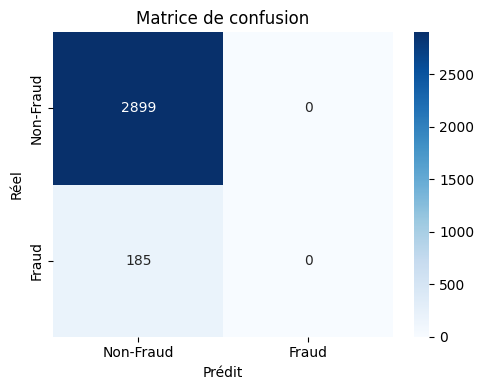

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.tight_layout()
plt.show()

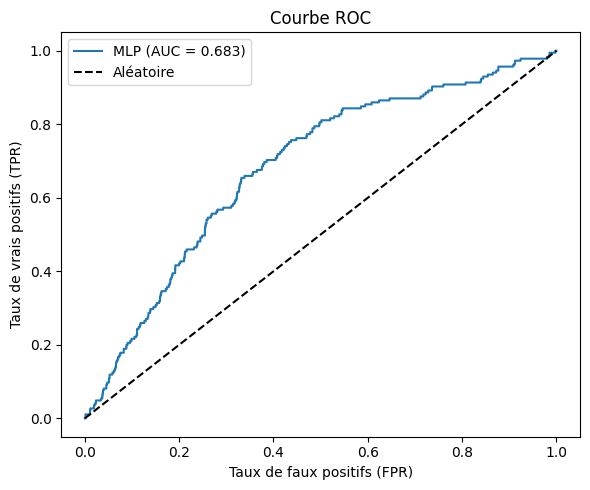


AUC-ROC : 0.6833


In [22]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score   = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"MLP (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Aléatoire")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(); plt.tight_layout()
plt.show()

print(f"\nAUC-ROC : {auc_score:.4f}")

In [23]:
#Utilisons maintenant un modèle de Machine Learning afin de comparer les résultats
#avec la méthode de Deep Learning
print("══════════════════════════════════════════════")
print("       RÉGRESSION LOGISTIQUE     ")
print("══════════════════════════════════════════════")

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

#Modélisation de la regression logistique
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, average="binary")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")




══════════════════════════════════════════════
       RÉGRESSION LOGISTIQUE     
══════════════════════════════════════════════
Accuracy: 0.6132
Precision: 0.1232
Recall: 0.8918
F1-Score: 0.2165


In [24]:
from sklearn.ensemble import RandomForestClassifier

print("══════════════════════════════════════════════")
print("            RANDOM FOREST                    ")
print("══════════════════════════════════════════════")

# Modélisation du Random Forest
# class_weight='balanced' pour gérer le déséquilibre (~6% de fraudes)
# n_estimators=200 : 200 arbres de décision — bon compromis performance/temps
# max_depth=10 : limite la profondeur pour éviter l'overfitting
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# On utilise les données retraitées de la régression logistique
# (même split X_train / X_test avec StandardScaler)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

accuracy_rf = accuracy_score(y_true=y_test, y_pred=y_pred_rf)
precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(
    y_true=y_test, y_pred=y_pred_rf, average='binary')

print(f"Accuracy  : {accuracy_rf:.4f}")
print(f"Precision : {precision_rf:.4f}")
print(f"Recall    : {recall_rf:.4f}")
print(f"F1-Score  : {f1_rf:.4f}")

print("\n── Rapport de classification ──")
print(classification_report(y_test, y_pred_rf, target_names=['Non-Fraud', 'Fraud']))

══════════════════════════════════════════════
            RANDOM FOREST                    
══════════════════════════════════════════════
Accuracy  : 0.6661
Precision : 0.1338
Recall    : 0.8355
F1-Score  : 0.2307

── Rapport de classification ──
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.66      0.79      3624
       Fraud       0.13      0.84      0.23       231

    accuracy                           0.67      3855
   macro avg       0.56      0.75      0.51      3855
weighted avg       0.93      0.67      0.75      3855



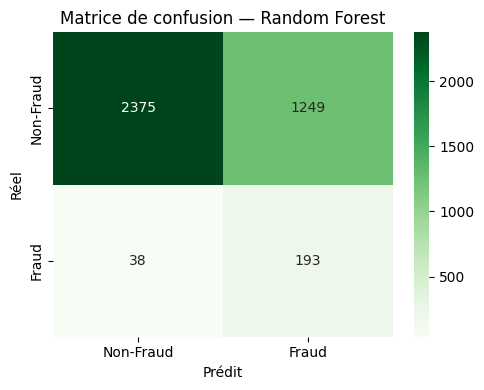

In [25]:
# Matrice de confusion — Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Prédit'); plt.ylabel('Réel')
plt.title('Matrice de confusion — Random Forest')
plt.tight_layout()
plt.show()

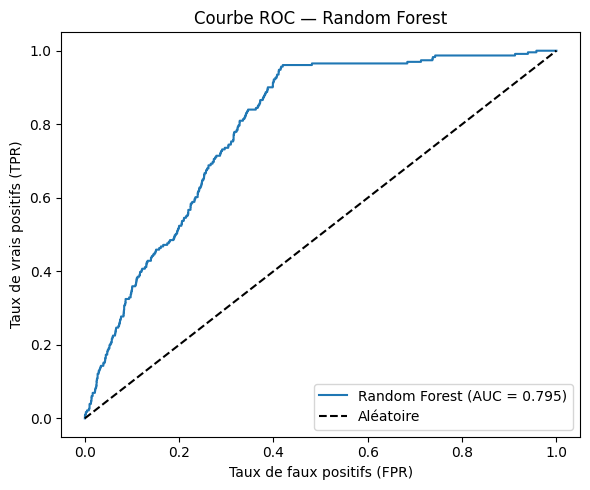


AUC-ROC : 0.7945


In [26]:
# Courbe ROC — Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC — Random Forest')
plt.legend(); plt.tight_layout()
plt.show()

print(f"\nAUC-ROC : {auc_rf:.4f}")

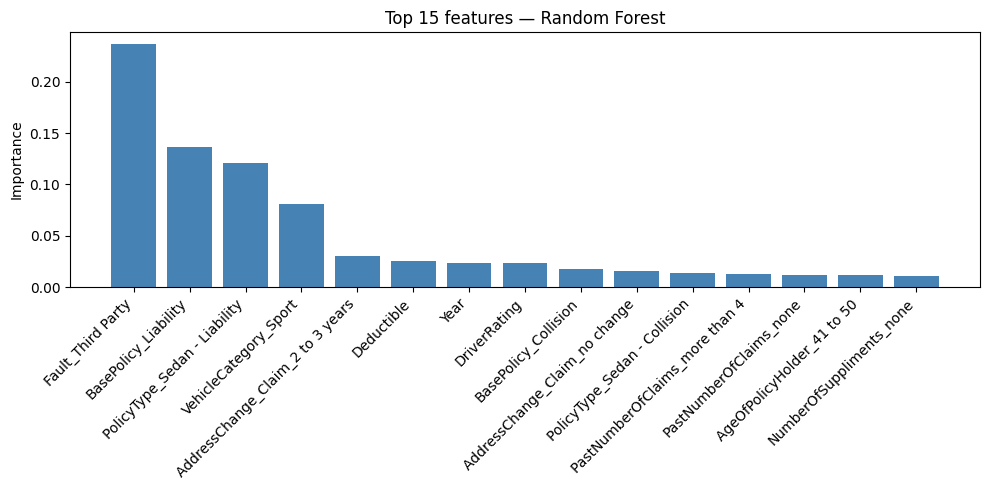

In [27]:
# Importance des variables — Random Forest
# On affiche les 15 features les plus importantes pour interpréter le modèle
feature_names = list(df_encoded.drop(columns=['FraudFound_P']).columns)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(10, 5))
plt.bar(range(15), importances[indices], color='steelblue')
plt.xticks(range(15), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.title('Top 15 features — Random Forest')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [28]:
from xgboost import XGBClassifier

print("══════════════════════════════════════════════")
print("               XGBOOST                       ")
print("══════════════════════════════════════════════")

# Calcul du ratio négatif/positif pour scale_pos_weight
# Équivalent au class_weight='balanced' pour XGBoost
# scale_pos_weight = nb_négatifs / nb_positifs ≈ 15.7 dans notre dataset
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
scale = neg / pos
print(f"scale_pos_weight utilisé : {scale:.2f}")

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=scale,   # gestion du déséquilibre des classes
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

accuracy_xgb = accuracy_score(y_true=y_test, y_pred=y_pred_xgb)
precision_xgb, recall_xgb, f1_xgb, _ = precision_recall_fscore_support(
    y_true=y_test, y_pred=y_pred_xgb, average='binary')

print(f"Accuracy  : {accuracy_xgb:.4f}")
print(f"Precision : {precision_xgb:.4f}")
print(f"Recall    : {recall_xgb:.4f}")
print(f"F1-Score  : {f1_xgb:.4f}")

print("\n── Rapport de classification ──")
print(classification_report(y_test, y_pred_xgb, target_names=['Non-Fraud', 'Fraud']))

══════════════════════════════════════════════
               XGBOOST                       
══════════════════════════════════════════════
scale_pos_weight utilisé : 15.71
Accuracy  : 0.7333
Precision : 0.1381
Recall    : 0.6580
F1-Score  : 0.2282

── Rapport de classification ──
              precision    recall  f1-score   support

   Non-Fraud       0.97      0.74      0.84      3624
       Fraud       0.14      0.66      0.23       231

    accuracy                           0.73      3855
   macro avg       0.55      0.70      0.53      3855
weighted avg       0.92      0.73      0.80      3855



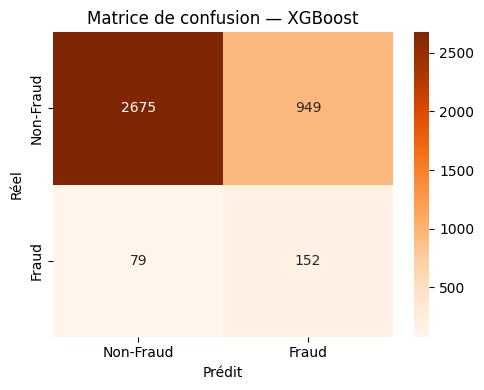

In [29]:
# Matrice de confusion — XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Prédit'); plt.ylabel('Réel')
plt.title('Matrice de confusion — XGBoost')
plt.tight_layout()
plt.show()

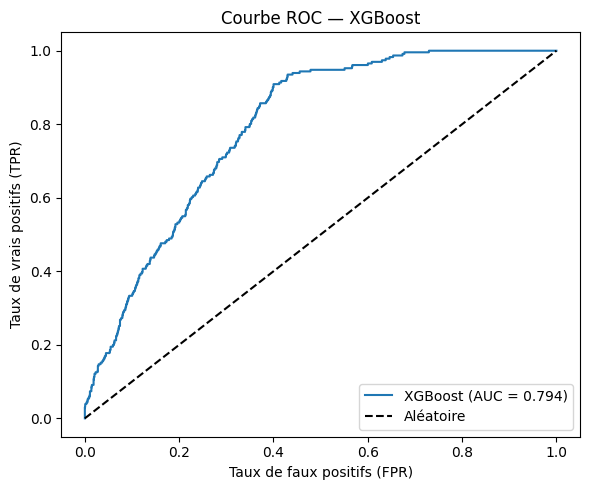


AUC-ROC : 0.7937


In [30]:
# Courbe ROC — XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

plt.figure(figsize=(6, 5))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC — XGBoost')
plt.legend(); plt.tight_layout()
plt.show()

print(f"\nAUC-ROC : {auc_xgb:.4f}")

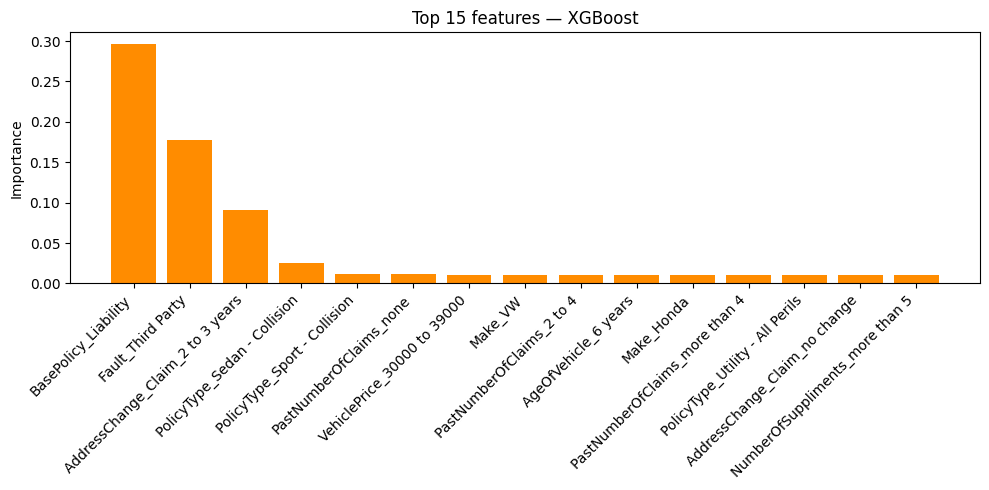

In [31]:
# Importance des variables — XGBoost
importances_xgb = xgb_model.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1][:15]

plt.figure(figsize=(10, 5))
plt.bar(range(15), importances_xgb[indices_xgb], color='darkorange')
plt.xticks(range(15), [feature_names[i] for i in indices_xgb], rotation=45, ha='right')
plt.title('Top 15 features — XGBoost')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [32]:
# ══════════════════════════════════════════════
# COMPARAISON FINALE DES MODÈLES
# ══════════════════════════════════════════════

resultats_comparaison = pd.DataFrame({
    'Modèle'    : ['Régression Logistique', 'Random Forest', 'XGBoost'],
    'Accuracy'  : [accuracy,     accuracy_rf,  accuracy_xgb],
    'Precision' : [precision,    precision_rf, precision_xgb],
    'Recall'    : [recall,        recall_rf,   recall_xgb],
    'F1-Score'  : [f1_score,      f1_rf,       f1_xgb],
    'AUC-ROC'   : [roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]),
                   auc_rf, auc_xgb]
})

resultats_comparaison = resultats_comparaison.set_index('Modèle').round(4)
print(resultats_comparaison.to_string())

                       Accuracy  Precision  Recall  F1-Score  AUC-ROC
Modèle                                                               
Régression Logistique    0.6132     0.1232  0.8918    0.2165   0.7876
Random Forest            0.6661     0.1338  0.8355    0.2307   0.7945
XGBoost                  0.7333     0.1381  0.6580    0.2282   0.7937


Les trois modèles ont une AUC similaire (~0.79), ce qui montre qu’ils ont une capacité de séparation comparable.

La différence principale réside dans le compromis precision / recall :

Régression Logistique → maximise le recall

*   Régression Logistique → maximise le recall
*   XGBoost → maximise l’accuracy
*   Random Forest → meilleur équilibre global


Aucun modèle ne domine clairement sur toutes les métriques, ce qui justifie d’explorer une approche plus flexible comme le MLP pour tenter d’améliorer la séparation globale et le compromis précision / rappel.

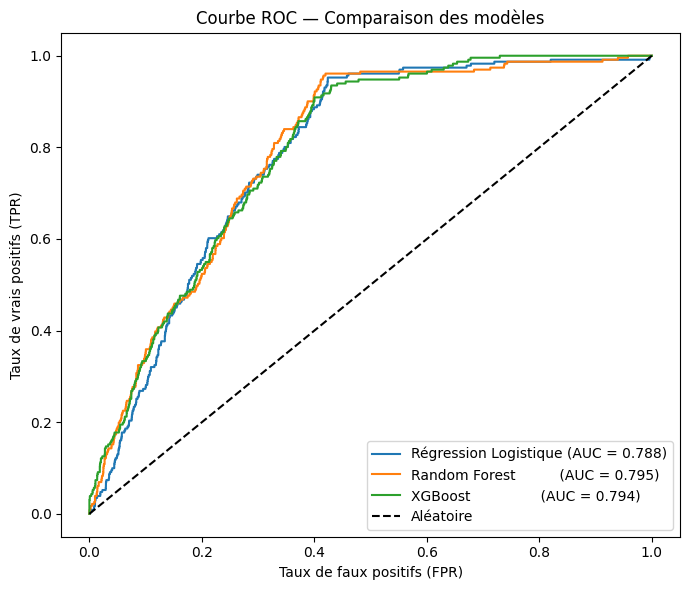

In [33]:
# Courbe ROC comparative — les 3 modèles sur le même graphique
fpr_lr, tpr_lr, _ = roc_curve(y_test,
    model.predict_proba(X_test_scaled)[:, 1])
auc_lr = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

plt.figure(figsize=(7, 6))
plt.plot(fpr_lr,  tpr_lr,  label=f'Régression Logistique (AUC = {auc_lr:.3f})')
plt.plot(fpr_rf,  tpr_rf,  label=f'Random Forest          (AUC = {auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost                (AUC = {auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC — Comparaison des modèles')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Les méthodes traditionnelles présentent certaines limites :

La régression logistique est strictement linéaire.

*   La régression logistique est strictement linéaire.
*   Random Forest et XGBoost capturent des non-linéarités mais restent basés sur des partitions d’arbres.

*   Les interactions complexes entre variables catégorielles encodées peuvent être difficiles à modéliser finement.

Un réseau de neurones (MLP) permettrait d’apprendre des combinaisons non linéaires plus riches , de capturer des interactions complexes entre variables
et d’optimiser directement la fonction de perte via descente de gradient

L’objectif est donc de voir si le MLP permet :

d’améliorer l’AUC au-delà de 0.79

d’obtenir un meilleur compromis precision / recall

de mieux séparer les fraudes des non-fraudes